# Permutation tests

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from param import *
from modules.utils.plot_utils import label_diff

output_dir = ParamDir().output_dir
datalist = ParamDir().data_path_list

## SVM

In [4]:
significance_results = []
for data_dir in datalist:
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "KO" if "KO" in data_name else "WT"
    with open(ParamDir().output_dir/data_name/"tsc_shuffle_f1_SVM_False_train_rocket.pickle","rb") as f:
        shuffle_results = pickle.load(f)
    with open(ParamDir().output_dir/data_name/"tsc_f1_train_rocket_SVM_threshold_segment_False.pickle","rb") as f:
        original_results = pickle.load(f)
    shuffle_scores = np.array([res['scores'] for res in shuffle_results])
    score = original_results['scores']
    cv_mean = original_results["estimator"].cv_results_['mean_test_score'][-1]
    cv_std = original_results["estimator"].cv_results_['std_test_score'][-1]
    significance_results.append([shuffle_scores, score, cv_std, cv_mean, data_name, mouse_type])

In [5]:
df = pd.DataFrame(significance_results, columns=["shuffle scores", "score", "cv std", "cv mean", "data name", "mouse type"])
df

,shuffle scores,score,cv std,cv mean,data name,mouse type
0,"[0.0, 0.25, 0.0, 0.75, 0.5, 0.125, 0.625, 0.25...",0.625000,0.156036,0.499667,091317 OF CaMKII HKO M19-n1,KO
1,"[0.375, 0.25, 0.08333333333333333, 0.125, 0.12...",0.291667,0.174885,0.298268,092217 OF CaMKII HKO M30-n1,KO
2,"[0.0, 0.375, 0.125, 0.375, 0.125, 0.25, 0.375,...",0.375000,0.126004,0.307576,M45_042718_OF,WT
3,"[0.4166666666666667, 0.25, 0.08333333333333333...",0.333333,0.080770,0.358480,091317 OF CaMKII HKO M20-n1,KO
4,"[0.25, 0.375, 0.1875, 0.1875, 0.3125, 0.625, 0...",0.375000,0.226313,0.535789,M46_042718_OF,WT
5,"[0.28125, 0.3125, 0.25, 0.25, 0.3125, 0.28125,...",0.250000,0.143527,0.220000,CK_KO_RN1_OF,KO
6,"[0.3333333333333333, 0.25, 0.4166666666666667,...",0.541667,0.245071,0.382857,CK_WT_RN3_OF,WT
7,"[0.1875, 0.375, 0.375, 0.375, 0.25, 0.1875, 0....",0.375000,0.218302,0.392647,090817 OF CaMKII HKO M22-n1,KO
8,"[0.1875, 0.1875, 0.4375, 0.375, 0.25, 0.3125, ...",0.250000,0.249692,0.479085,092217 OF CaMKII WT M29-n1,WT
9,"[0.25, 0.125, 0.25, 0.16666666666666666, 0.208...",0.666667,0.166013,0.441991,M44_042718_OF,WT


Text(0.5, 0.98, 'decoding results')

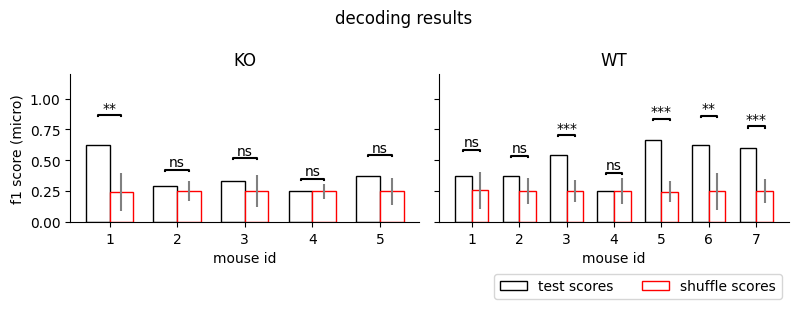

In [8]:
fig, axes = plt.subplots(figsize=(8,3), ncols=2, sharey=True, tight_layout=True)
sns.despine()

for plot_i, mouse_type in enumerate(df["mouse type"].unique()):
       plot_df = df[df["mouse type"]==mouse_type]
       ax = axes[plot_i]

       ind = np.arange(1, len(plot_df)+1)
       width = 0.35  # the width of the bars
       score = plot_df["score"].values
       cv_error = plot_df["cv std"].values
       shuffle_mean = [i.mean() for i in plot_df["shuffle scores"].values] # mean for each mouse
       shuffle_error = [i.std() for i in plot_df["shuffle scores"].values] # std for each mouse

       # for CV sores
       lin1 = ax.bar(ind-width/2, score, 
              width,
              # yerr=cv_error,
              facecolor="white", 
              edgecolor="black",
              ecolor="grey",
              label="test scores")

       # for shuffle
       lin2 = ax.bar(ind+width/2, shuffle_mean, 
              width,
              yerr=shuffle_error,
              facecolor="white", 
              edgecolor="r",
              ecolor="grey",
              label="shuffle scores")
       
       ax.set_title(mouse_type)
       ax.set_xlabel("mouse id")
       
       # significance marks
       for mouse_id in range(len(ind)):
              # significance mark
              if np.quantile(plot_df["shuffle scores"].values[mouse_id], 0.999) <= score[mouse_id]:
                     sig_mk = "***"
              elif np.quantile(plot_df["shuffle scores"].values[mouse_id], 0.99) <= score[mouse_id]:
                     sig_mk = "**"
              elif np.quantile(plot_df["shuffle scores"].values[mouse_id], 0.95) <= score[mouse_id]:
                     sig_mk = "*"
              else:
                     sig_mk = "ns"
              sub_ind = [ind[mouse_id]-width/2, ind[mouse_id]+width/2]
              sub_score = [score[mouse_id], shuffle_mean[mouse_id]]
              sub_error = [shuffle_error[mouse_id], shuffle_error[mouse_id]]
              label_diff(0, 1, sig_mk, ind=sub_ind, Y=sub_score, errors=sub_error, ax=ax, barh=.01)

axes[0].set_ylabel("f1 score (micro)")
axes[0].set_ylim(0,1.2)
plt.legend([
    lin1[0], lin2[0]], [l.get_label() for l in [lin1, lin2]], 
    ncol=2, 
    bbox_to_anchor=(1,-.3))
plt.suptitle("decoding results")